In [37]:
import glob
import os
import shutil
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image                              # (pip install Pillow)
import numpy as np                                 # (pip install numpy)
from skimage import measure                        # (pip install scikit-image)
from shapely.geometry import Polygon, MultiPolygon # (pip install Shapely)

We download the dataset from https://www.scidb.cn/en/detail?dataSetId=0e1f57004db842f99668d82183afd578&dataSetType=personal


We extract the data from the rar file and store it in path ./data/ATLDSD

In [2]:
not_renamed = True

In [3]:
!rm -rf ./data/ATLDSD
!unrar x ./data/ATLDSD.rar ./data


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from ./data/ATLDSD.rar

Creating    ./data/ATLDSD                                             OK
Creating    ./data/ATLDSD/Alternaria leaf spot                        OK
Creating    ./data/ATLDSD/Alternaria leaf spot/image                  OK
Extracting  ./data/ATLDSD/Alternaria leaf spot/image/000413.jpg          0  OK 
Extracting  ./data/ATLDSD/Alternaria leaf spot/image/000414.jpg          0  OK 
Extracting  ./data/ATLDSD/Alternaria leaf spot/image/000415.jpg          0  OK 
Extracting  ./data/ATLDSD/Alternaria leaf spot/image/000416.jpg          0  OK 
Extracting  ./data/ATLDSD/Alternaria leaf spot/image/000417.jpg          0  OK 
Extracting  ./data/ATLDSD/Alternaria leaf spot/image/000418.jpg          0  OK 
Extracting  ./data/ATLDSD/Alternaria leaf spot/image/000420.jpg          0  OK 
Extracting  ./data/ATLDSD/Alternaria leaf spot/image/000421.jpg          0  OK 
Extracting  ./data/ATLDSD/Alte

We check the file format for the masks and the images.

In [4]:
img = Image.open('data/ATLDSD/Alternaria leaf spot/image/000414.jpg')
print(type(img))
img=np.array(img)
print(type(img))
print(img.shape)

<class 'PIL.PngImagePlugin.PngImageFile'>
<class 'numpy.ndarray'>
(256, 256, 3)


In [5]:
mask = Image.open('data/ATLDSD/Alternaria leaf spot/label/000414.png')
print(type(mask))
mask=np.array(mask)
print(type(mask))
print(mask.shape)

<class 'PIL.PngImagePlugin.PngImageFile'>
<class 'numpy.ndarray'>
(256, 256)


In [6]:
mask = Image.open('data/ATLDSD/Alternaria leaf spot/label/000414.png')
print(type(mask))
mask = mask.convert('RGB')
mask=np.array(mask)
print(type(mask))
print(mask.shape)

<class 'PIL.PngImagePlugin.PngImageFile'>
<class 'numpy.ndarray'>
(256, 256, 3)


We display the image

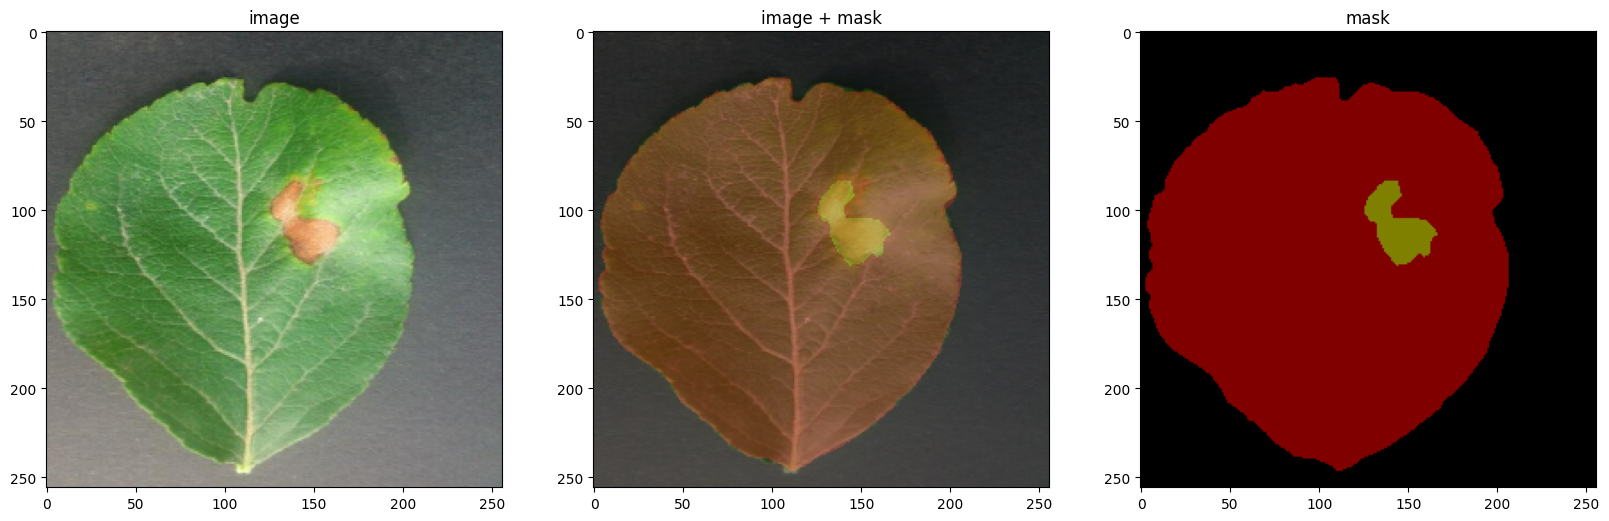

In [7]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.title('image')
plt.imshow(img) # I would add interpolation='none'
plt.subplot(1,3,3)
plt.title('mask')
plt.imshow(mask) # interpolation='none'
plt.subplot(1,3,2)
plt.title('image + mask')
plt.imshow(img) # I would add interpolation='none'
plt.imshow(mask, alpha=0.5) # interpolation='none'

We create a dataframe with the image and mask paths and the category name and id 
 
We add an image id and an image name composed of category name and image id

In [8]:
categories = {'alternaria_leaf_spot': 0,
              'brown_spot': 1,
              'gray_spot': 2,
              'rust': 3,
              'healthy_leaf': 4}

data = {
        'image_id':[],
        'name':[],
        'image':[],
        'mask':[],
        # 'segmentation':[],
        # 'bbox':[],
        'category':[],
        'category_id':[]
        }

i = 1
for current_dir, dirs, files in os.walk('data/ATLDSD/'):
    if files :
        for image in files:
            if image.endswith('.jpg') | image.endswith('.JPG'):
                current_dir = current_dir.replace('\\', '/')
                base_name = current_dir.split('/')[-2]
                base_name = base_name.replace(' ', '_')
                data['image_id'].append(i)
                data['name'].append(f"{base_name}_{i}")
                i+=1
                image = './' + current_dir + '/' + image
                data['image'].append(image)
                mask = image.replace('.jpg', '.png').replace('.JPG','.png').replace('image', 'label')
                data['mask'].append(mask)
                # data['segmentations'].append([])
                # data['bboxes'].append([])
                label = current_dir.split('/')[-2].replace(' ', '_').lower()
                data['category'].append(label)
                label_id = categories[label]
                data['category_id'].append(label_id)

dataframe = pd.DataFrame.from_dict(data)
dataframe.head()

image_id            name  \
0         1  Healthy_leaf_1   
1         2  Healthy_leaf_2   
2         3  Healthy_leaf_3   
3         4  Healthy_leaf_4   
4         5  Healthy_leaf_5   

                                               image  \
0  ./data/ATLDSD/Healthy leaf/image/IMG_20190726_...   
1  ./data/ATLDSD/Healthy leaf/image/IMG_20190726_...   
2  ./data/ATLDSD/Healthy leaf/image/IMG_20190726_...   
3  ./data/ATLDSD/Healthy leaf/image/IMG_20190726_...   
4  ./data/ATLDSD/Healthy leaf/image/IMG_20190726_...   

                                                mask      category  \
0  ./data/ATLDSD/Healthy leaf/label/IMG_20190726_...  healthy_leaf   
1  ./data/ATLDSD/Healthy leaf/label/IMG_20190726_...  healthy_leaf   
2  ./data/ATLDSD/Healthy leaf/label/IMG_20190726_...  healthy_leaf   
3  ./data/ATLDSD/Healthy leaf/label/IMG_20190726_...  healthy_leaf   
4  ./data/ATLDSD/Healthy leaf/label/IMG_20190726_...  healthy_leaf   

   category_id  
0            4  
1            4  
2            4  
3            4  
4            4

In [9]:
dataframe.loc[0, ['name', 'image', 'mask']].values


array(['Healthy_leaf_1',
       './data/ATLDSD/Healthy leaf/image/IMG_20190726_192618.jpg',
       './data/ATLDSD/Healthy leaf/label/IMG_20190726_192618.png'],
      dtype=object)

We rename files with classe name and id

In [10]:
def rename_images(row):
    name = row['name']
    old_im_path = row['image']
    new_im_path = '/'.join(row['image'].split('/')[0:-1]) + f"/{name}.jpg"
    row['image'] = new_im_path
    os.rename(old_im_path, new_im_path)
    old_mask_path = row['mask']
    new_mask_path = '/'.join(row['mask'].split('/')[0:-1]) + f"/{name}.png"
    row['mask'] = new_mask_path
    os.rename(old_mask_path, new_mask_path)
    return row


if not_renamed:
    not_renamed = False
    dataframe = dataframe.apply(rename_images, axis=1)


We check the proportion of each class

In [11]:
dataframe.value_counts('category')

category
healthy_leaf            409
gray_spot               395
rust                    344
alternaria_leaf_spot    278
brown_spot              215
dtype: int64

In [12]:
dataframe.value_counts('category', normalize=True)

category
healthy_leaf            0.249238
gray_spot               0.240707
rust                    0.209628
alternaria_leaf_spot    0.169409
brown_spot              0.131018
dtype: float64

We check if image and mask are consistent

In [13]:
for r in dataframe.iterrows():
    image = Image.open(r[1]['image']).convert('RGB')
    mask = Image.open(r[1]['mask']).convert('RGB')
    np_image = np.array(image)
    np_mask = np.array(mask)
    if np_image.shape != np_mask.shape:
        print('image and mask are not the same shape for', r[1]['image'])
    if np_image.shape[0] != 256 or np_image.shape[1] != 256:
        print('image is not 256x256 for', r[1]['image'])
    if np_mask.shape[0] != 256 or np_mask.shape[1] != 256:
        print('mask is not 256x256 for', r[1]['image'])
    if np_image.shape[2] != 3:
        print('image is not RGB for', r[1]['image'])
    if np_mask.shape[2] != 3:
        print('mask is not RGB for', r[1]['image'])
    if np_mask.max() > 2128 or np_mask.min() < 0:
        print('mask is not between 0 and 2128 for', r[1]['image'])

We display random images from dataset

/tmp/ipykernel_50012/3873676188.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


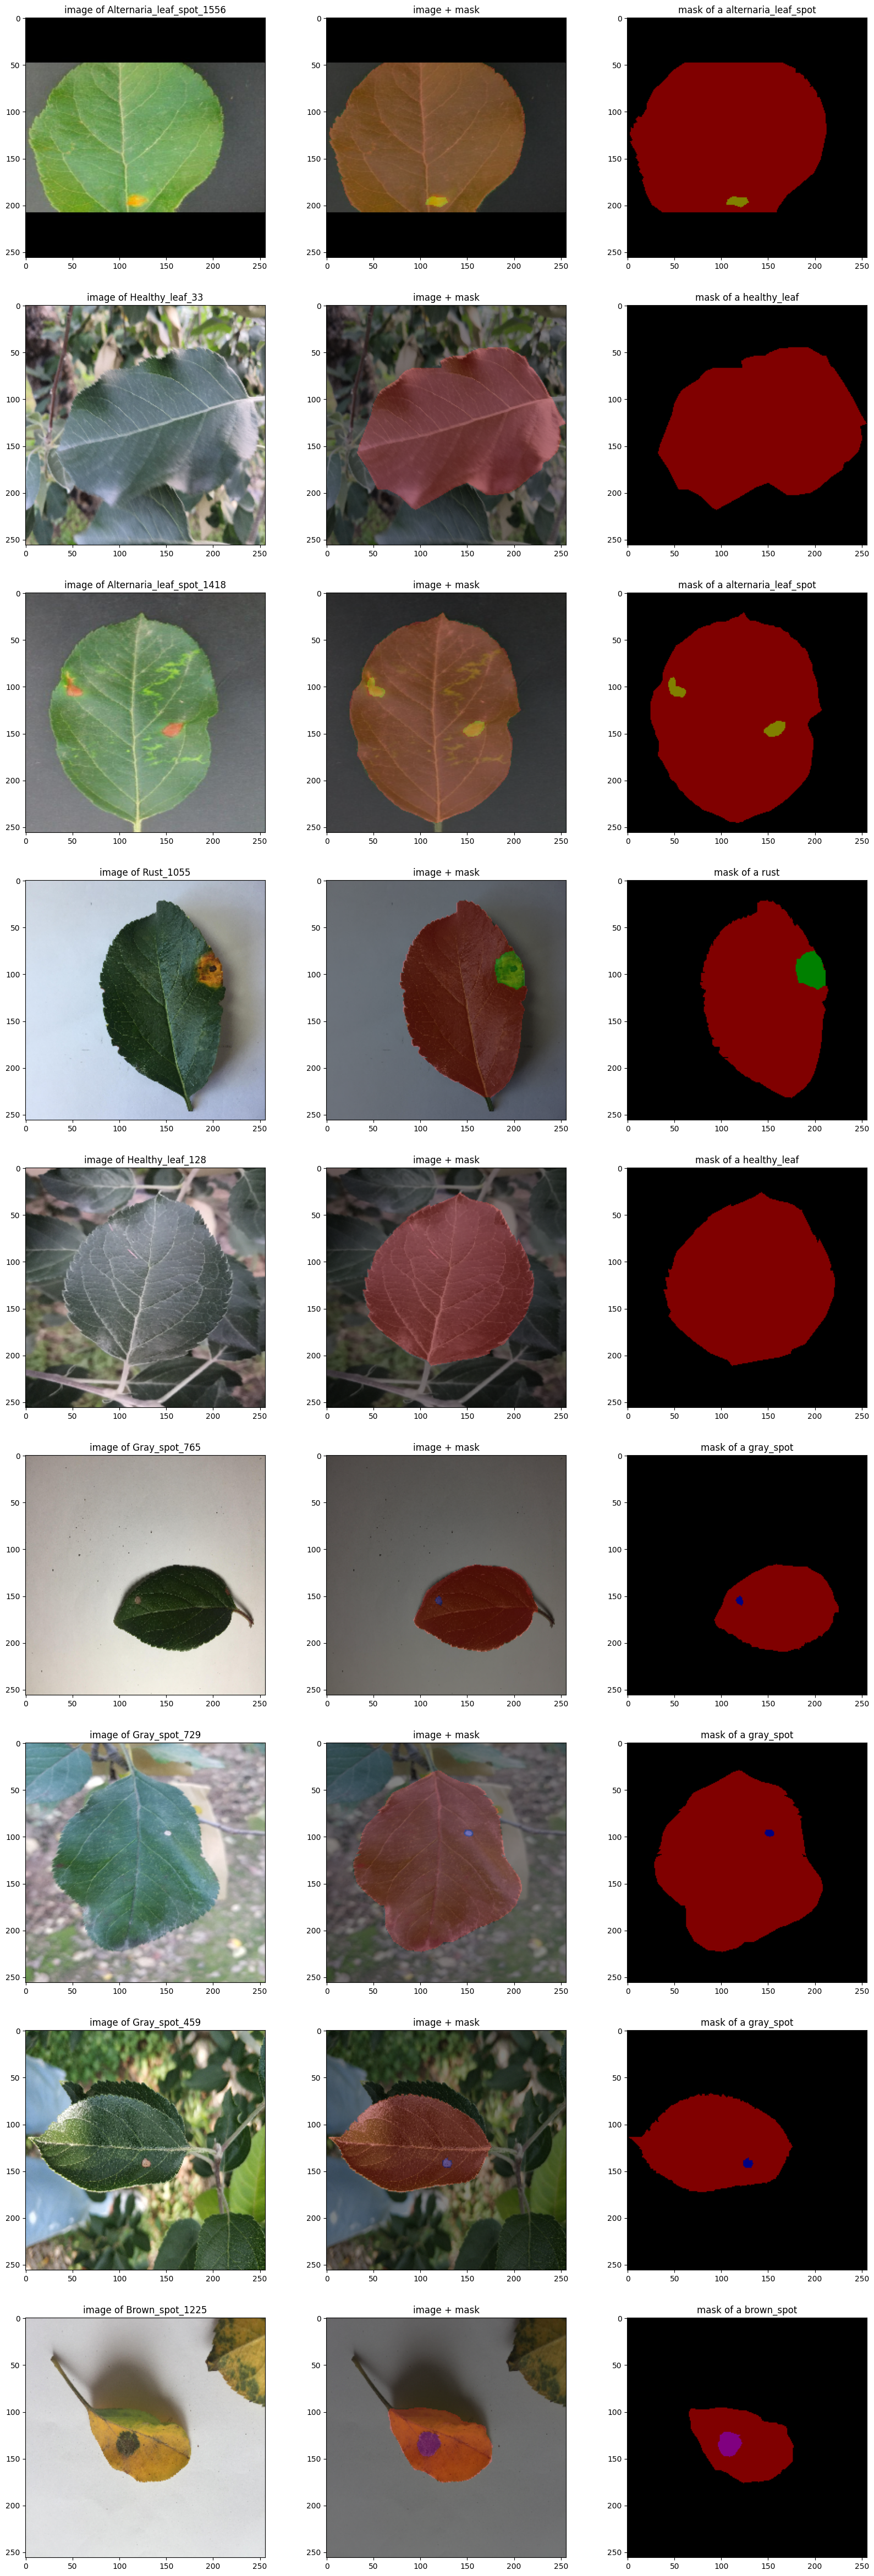

In [14]:
fig, axs = plt.subplots(9,3, figsize=(20,60))

for i in range(9):
    
    random_index = np.random.randint(0, dataframe.shape[0])

    test = dataframe.loc[random_index,:] # random row
        
    image = Image.open(test['image']).convert('RGB')
    mask = Image.open(test['mask']).convert('RGB')

    np_image = np.array(image)
    np_mask = np.array(mask)

    axs[i,0].set_title('image of ' + test['name'])
    axs[i,0].imshow(np_image)

    axs[i,1].set_title('image + mask')
    axs[i,1].imshow(np_image)
    axs[i,1].imshow(np_mask, alpha=0.5)

    axs[i,2].set_title('mask of a ' + test['category'])
    axs[i,2].imshow(np_mask)

fig.show()

Splitting dataset into training, validation and testing with 80%, 10% and 10% respectively

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
temp, test = train_test_split(dataframe, test_size=0.1, random_state=42, stratify=dataframe['category'])
train, val = train_test_split(temp, test_size=0.1, random_state=42, stratify=temp['category'])

In [33]:
category_split = {
    'train': {
        'norm' : train.category.value_counts(normalize=True),
        'count': train.category.value_counts(),
    },
    'val': {
        'norm': val.category.value_counts(normalize=True),
        'count': val.category.value_counts(),
    },
    'test': {
        'norm': test.category.value_counts(normalize=True),
        'count': test.category.value_counts(),
    },
}
category_split

{'train': {'norm': healthy_leaf            0.249247
  gray_spot               0.240211
  rust                    0.210090
  alternaria_leaf_spot    0.169428
  brown_spot              0.131024
  Name: category, dtype: float64,
  'count': healthy_leaf            331
  gray_spot               319
  rust                    279
  alternaria_leaf_spot    225
  brown_spot              174
  Name: category, dtype: int64},
 'val': {'norm': healthy_leaf            0.250000
  gray_spot               0.243243
  rust                    0.209459
  alternaria_leaf_spot    0.168919
  brown_spot              0.128378
  Name: category, dtype: float64,
  'count': healthy_leaf            37
  gray_spot               36
  rust                    31
  alternaria_leaf_spot    25
  brown_spot              19
  Name: category, dtype: int64},
 'test': {'norm': healthy_leaf            0.248485
  gray_spot               0.242424
  rust                    0.206061
  alternaria_leaf_spot    0.169697
  brown_spot   

Creating COCO dataset folder structure

In [18]:
!rm -rf ./data/COCO_Format

!mkdir ./data/COCO_Format

for keyword in ["train", "val", "test"]:
    !mkdir ./data/COCO_Format/{keyword}
    !mkdir ./data/COCO_Format/{keyword}/images
    !mkdir ./data/COCO_Format/{keyword}/labels

In [42]:
def move_images_masks(dataframe, path : str):
    path = Path(path)
    if not path.exists() or not path.is_dir():
        raise ValueError(f"Path {path} does not exist or is not a directory")
    for index, row in dataframe.iterrows():
        img_path = Path(row['image'])
        shutil.copy(img_path, path / 'images')
        # !cp {img_path} {path + 'images/'}
        mask_path = Path(row['mask'])
        shutil.copy(mask_path, path / 'labels')
        # !cp {mask_path} {path + 'labels/'}

move_images_masks(train, './data/COCO_Format/train/')
move_images_masks(val, './data/COCO_Format/val/')
move_images_masks(test, './data/COCO_Format/test/')

We convert mask to COCO annotations format

In [43]:
from PIL import Image                                      # (pip install Pillow)
import numpy as np                                         # (pip install numpy)
from skimage import measure                                # (pip install scikit-image)
from shapely.geometry import Polygon, MultiPolygon         # (pip install Shapely)
import os
import json

def create_sub_masks(mask_image, width, height):
    # Initialize a dictionary of sub-masks indexed by RGB colors
    sub_masks = {}
    for x in range(width):
        for y in range(height):
            # Get the RGB values of the pixel
            pixel = mask_image.getpixel((x,y))[:3]

            # Check to see if we have created a sub-mask...
            pixel_str = str(pixel)
            sub_mask = sub_masks.get(pixel_str)
            if sub_mask is None:
               # Create a sub-mask (one bit per pixel) and add to the dictionary
                # Note: we add 1 pixel of padding in each direction
                # because the contours module doesn"t handle cases
                # where pixels bleed to the edge of the image
                sub_masks[pixel_str] = Image.new("1", (width+2, height+2))

            # Set the pixel value to 1 (default is 0), accounting for padding
            sub_masks[pixel_str].putpixel((x+1, y+1), 1)

    return sub_masks

def create_sub_mask_annotation(sub_mask):
    # Find contours (boundary lines) around each sub-mask
    # Note: there could be multiple contours if the object
    # is partially occluded. (E.g. an elephant behind a tree)
    contours = measure.find_contours(np.array(sub_mask), 0.5, positive_orientation="low")

    polygons = []
    segmentations = []
    for contour in contours:
        # Flip from (row, col) representation to (x, y)
        # and subtract the padding pixel
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)

        # Make a polygon and simplify it
        poly = Polygon(contour)
        poly = poly.simplify(1.0, preserve_topology=True) # Had to preserve topology to avoid errors
        
        if(poly.is_empty):
            # Go to next iteration, dont save empty values in list
            continue

        polygons.append(poly)

        segmentation = np.array(poly.exterior.coords).ravel().tolist()
        segmentations.append(segmentation)
    
    return polygons, segmentations

def create_category_annotation(category_dict):
    category_list = []

    for key, value in category_dict.items():
        category = {
            "supercategory": key,
            "id": value,
            "name": key
        }
        category_list.append(category)

    return category_list

def create_image_annotation(file_name, width, height, image_id):
    images = {
        "file_name": file_name,
        "height": height,
        "width": width,
        "id": image_id
    }

    return images

def create_annotation_format(polygon, segmentation, image_id, category_id, annotation_id):
    min_x, min_y, max_x, max_y = polygon.bounds
    width = max_x - min_x
    height = max_y - min_y
    bbox = (min_x, min_y, width, height)
    area = polygon.area

    annotation = {
        "segmentation": segmentation,
        "area": area,
        "iscrowd": 0,
        "image_id": image_id,
        "bbox": bbox,
        "category_id": category_id,
        "id": annotation_id
    }

    return annotation

def get_coco_json_format():
    # Standard COCO format 
    coco_format = {
        "info": {},
        "licenses": [],
        "images": [{}],
        "categories": [{}],
        "annotations": [{}]
    }

    return coco_format


In [44]:
# Label ids of the dataset
category_ids = {
    "alternaria_leaf_spot": 0,
    "brown_spot": 1,
    "gray_spot": 2,
    "rust": 3,
    "healthy_leaf": 4,
}

# Define which colors match which categories in the images
category_id_by_color = {
    '(128, 128, 0)': {
        'category_id' : 0, 
    },
    '(128, 0, 128)': {
        'category_id' : 1,
    },
    '(0, 0, 128)' : {
        'category_id' : 2,   
    },
    '(0, 128, 0)' : {
        'category_id' : 3,
    },
    '(128, 0, 0)' : {
        'category_id' : 4, 
    }
}
category_colors = {
    "(128, 128, 0)": 0, # Alternaria leaf spot
    "(128, 0, 128)": 1, # Brown spot
    "(0, 0, 128)": 2, # Gray spot
    "(0, 128, 0)": 3, # Rust
    "(128, 0, 0)": 4, # Healthy leaf
}

# Define the ids that are a multiplolygon. In our case: wall, roof and sky
# multipolygon_ids = [0, 1, 2, 3, 4]
multipolygon_ids = [4]

# Get "images" and "annotations" info 
def images_annotations_info(maskpath):
    # This id will be automatically increased as we go
    annotation_id = 0
    image_id = 0
    annotations = []
    images = []
    print ("Processing images and annotations...")
    print ("Mask path: " + maskpath)
    for item in os.scandir(maskpath):
        if item.is_file():
            mask_image = item.path
            # The mask image is *.png but the original image is *.jpg.
            # We make a reference to the original file in the COCO JSON file
            original_file_name = item.name.split(".")[0] + ".jpg"

            # Open the image and (to be sure) we convert it to RGB
            mask_image_open = Image.open(mask_image).convert("RGB")
            w, h = mask_image_open.size
            
            # "images" info 
            image = create_image_annotation(original_file_name, w, h, image_id)
            images.append(image)

            sub_masks = create_sub_masks(mask_image_open, w, h)
            for color, sub_mask in sub_masks.items():
                if color == "(0, 0, 0)": # Ignore black pixels
                    continue
                if color not in category_colors:
                    print("Color not in category colors: " + color)
                    continue
                category_id = category_colors[color]

                # "annotations" info
                polygons, segmentations = create_sub_mask_annotation(sub_mask)

                # Check if we have classes that are a multipolygon
                if category_id in multipolygon_ids:
                    # Combine the polygons to calculate the bounding box and area
                    multi_poly = MultiPolygon(polygons)
                                    
                    annotation = create_annotation_format(multi_poly, segmentations, image_id, category_id, annotation_id)

                    annotations.append(annotation)
                    annotation_id += 1
                else:
                    for i in range(len(polygons)):
                        # Cleaner to recalculate this variable
                        segmentation = [np.array(polygons[i].exterior.coords).ravel().tolist()]
                        
                        annotation = create_annotation_format(polygons[i], segmentation, image_id, category_id, annotation_id)
                        
                        annotations.append(annotation)
                        annotation_id += 1
        image_id += 1
    return images, annotations, annotation_id


# Get the standard COCO JSON format
coco_format = get_coco_json_format()

for keyword in ["train", "val", "test"]:
    mask_path = "./data/COCO_Format/{}/labels".format(keyword)
    
    # Create category section
    coco_format["categories"] = create_category_annotation(category_ids)

    # Create images and annotations sections
    coco_format["images"], coco_format["annotations"], annotation_cnt = images_annotations_info(mask_path)

    with open("data/COCO_Format/{}/{}_no_multipoly.json".format(keyword, keyword),"w") as outfile:
        json.dump(coco_format, outfile)
    
    print("Created %d annotations for images in folder: %s" % (annotation_cnt, mask_path))


Processing images and annotations...
Mask path: ./data/COCO_Format/train/labels
Created 4655 annotations for images in folder: ./data/COCO_Format/train/labels
Processing images and annotations...
Mask path: ./data/COCO_Format/val/labels
Created 476 annotations for images in folder: ./data/COCO_Format/val/labels
Processing images and annotations...
Mask path: ./data/COCO_Format/test/labels
Created 606 annotations for images in folder: ./data/COCO_Format/test/labels


We convert COCO format to YOLO format

In [45]:
import json
import numpy as np
from PIL import ExifTags
from tqdm import tqdm
from collections import defaultdict

In [64]:

def make_dirs(dir='new_dir/'):
    # Create folders
    dir = Path(dir)
    if dir.exists():
        print('Warning: Deleting %s ...' % dir)
        shutil.rmtree(dir)  # delete dir
    for p in dir, dir / 'labels', dir / 'images':
        print('Creating %s ...' % p)
        p.mkdir(parents=True, exist_ok=True)  # make dir
    return dir

def min_index(arr1, arr2):
    """Find a pair of indexes with the shortest distance. 
    Args:
        arr1: (N, 2).
        arr2: (M, 2).
    Return:
        a pair of indexes(tuple).
    """
    dis = ((arr1[:, None, :] - arr2[None, :, :]) ** 2).sum(-1)
    return np.unravel_index(np.argmin(dis, axis=None), dis.shape)


def merge_multi_segment(segments):
    """Merge multi segments to one list.
    Find the coordinates with min distance between each segment,
    then connect these coordinates with one thin line to merge all 
    segments into one.

    Args:
        segments(List(List)): original segmentations in coco's json file.
            like [segmentation1, segmentation2,...], 
            each segmentation is a list of coordinates.
    """
    s = []
    segments = [np.array(i).reshape(-1, 2) for i in segments]
    idx_list = [[] for _ in range(len(segments))]

    # record the indexes with min distance between each segment
    for i in range(1, len(segments)):
        idx1, idx2 = min_index(segments[i - 1], segments[i])
        idx_list[i - 1].append(idx1)
        idx_list[i].append(idx2)

    # use two round to connect all the segments
    for k in range(2):
        # forward connection
        if k == 0:
            for i, idx in enumerate(idx_list):
                # middle segments have two indexes
                # reverse the index of middle segments
                if len(idx) == 2 and idx[0] > idx[1]:
                    idx = idx[::-1]
                    segments[i] = segments[i][::-1, :]

                segments[i] = np.roll(segments[i], -idx[0], axis=0)
                segments[i] = np.concatenate([segments[i], segments[i][:1]])
                # deal with the first segment and the last one
                if i in [0, len(idx_list) - 1]:
                    s.append(segments[i])
                else:
                    idx = [0, idx[1] - idx[0]]
                    s.append(segments[i][idx[0]:idx[1] + 1])

        else:
            for i in range(len(idx_list) - 1, -1, -1):
                if i not in [0, len(idx_list) - 1]:
                    idx = idx_list[i]
                    nidx = abs(idx[1] - idx[0])
                    s.append(segments[i][nidx:])
    return s



In [66]:
def convert_coco_json(json_dir='../coco/annotations/', yolo_dir='../yolo/', use_segments=False, cls91to80=False):
    save_dir = make_dirs(yolo_dir)  # output directory
    print('Converting %s to %s ...' % (json_dir, save_dir))
    # Import json
    for json_file in sorted(Path(json_dir).resolve().glob('*.json')):
        fn = Path(save_dir) / 'labels' # folder name
                
        with open(json_file) as f:
            data = json.load(f)

        # Create image dict
        images = {'%g' % x['id']: x for x in data['images']}
        # Create image-annotations dict
        imgToAnns = defaultdict(list)
        for ann in data['annotations']:
            imgToAnns[ann['image_id']].append(ann)

        # Write labels file
        for img_id, anns in tqdm(imgToAnns.items(), desc=f'Annotations {json_file}'):
            img = images['%g' % img_id]
            h, w, f = img['height'], img['width'], img['file_name']
            
            shutil.copyfile(os.path.join(json_dir, 'images', f), os.path.join(save_dir, 'images', f))
            
            bboxes = []
            segments = []
            for ann in anns:
                if ann['iscrowd']:
                    continue
                # The COCO box format is [top left x, top left y, width, height]
                box = np.array(ann['bbox'], dtype=np.float64)
                box[:2] += box[2:] / 2  # xy top-left corner to center
                box[[0, 2]] /= w  # normalize x
                box[[1, 3]] /= h  # normalize y
                if box[2] <= 0 or box[3] <= 0:  # if w <= 0 and h <= 0
                    continue

                cls = ann['category_id']  # class
                box = [cls] + box.tolist()
                if box not in bboxes:
                    bboxes.append(box)
                # Segments
                if use_segments:
                    if len(ann['segmentation']) > 1:
                        s = merge_multi_segment(ann['segmentation'])
                        s = (np.concatenate(s, axis=0) / np.array([w, h])).reshape(-1).tolist()
                    else:
                        s = [j for i in ann['segmentation'] for j in i]  # all segments concatenated
                        s = (np.array(s).reshape(-1, 2) / np.array([w, h])).reshape(-1).tolist()
                    s = [cls] + s
                    if s not in segments:
                        segments.append(s)

            # Write
            with open((fn / f).with_suffix('.txt'), 'a') as file:
                for i in range(len(bboxes)):
                    line = *(segments[i] if use_segments else bboxes[i]),  # cls, box or segments
                    file.write(('%g ' * len(line)).rstrip() % line + '\n')

In [73]:
coco_dir = f'./data/COCO_Format'
yolo_dir = f'./data/YOLO_Format'

for keyword in ["train", "val", "test"]:
    convert_coco_json(json_dir=coco_dir + f'/{keyword}', yolo_dir=yolo_dir + f'/{keyword}', use_segments=True, cls91to80=False)

Creating data/YOLO_Format/train ...
Creating data/YOLO_Format/train/labels ...
Creating data/YOLO_Format/train/images ...
Converting ./data/COCO_Format/train to data/YOLO_Format/train ...


Annotations /home/thomas/Documents/Learn/CompSci/cursus_e1/model/data/COCO_Format/train/train_no_multipoly.json: 100%|██████████| 1328/1328 [00:00<00:00, 2295.39it/s]


Creating data/YOLO_Format/val ...
Creating data/YOLO_Format/val/labels ...
Creating data/YOLO_Format/val/images ...
Converting ./data/COCO_Format/val to data/YOLO_Format/val ...


Annotations /home/thomas/Documents/Learn/CompSci/cursus_e1/model/data/COCO_Format/val/val_no_multipoly.json: 100%|██████████| 148/148 [00:00<00:00, 2254.04it/s]


Creating data/YOLO_Format/test ...
Creating data/YOLO_Format/test/labels ...
Creating data/YOLO_Format/test/images ...
Converting ./data/COCO_Format/test to data/YOLO_Format/test ...


Annotations /home/thomas/Documents/Learn/CompSci/cursus_e1/model/data/COCO_Format/test/test_no_multipoly.json: 100%|██████████| 165/165 [00:00<00:00, 1379.17it/s]


Write yolo dataset config file

In [74]:
category_ids

{'alternaria_leaf_spot': 0,
 'brown_spot': 1,
 'gray_spot': 2,
 'rust': 3,
 'healthy_leaf': 4}

In [80]:
with open(yolo_dir + '/ATLDSD.yaml', 'w') as f:
    f.write('train: ../../../' + yolo_dir + '/train/images\n')
    f.write('val: ../../../' + yolo_dir + '/val/images\n')
    f.write('test: ../../../' + yolo_dir + '/test/images\n')
    
    f.write('# number of classes\n')
    f.write('nc: 5\n')

    f.write('# class names\n')
    f.write('names: [\'alternaria_leaf_spot\', \'brown_spot\', \'gray_spot\', \'rust\', \'healthy_leaf\']\n')